Korte introductie, en doel van stage.

# Doelstelling

Aan de hand van PANDA een model of ecosysteem van modellen te ontwikkelen die de gleason score kan voorspellen adhv een digitalisering van een biopsis. (als supplement)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# DATA visualization
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from IPython.display import Image, display
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import openslide

In [ ]:
!pip install efficientnet_pytorch git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

# Exploratory Data Analysis

Wat uitleggen over de dataset en het doel ervan is. Zeggen waar het vandaag komt, welke staining, dat het wholeslide images zijn (tiff)

## Inladen van data

In [ ]:
BASE_FOLDER = "/kaggle/input/prostate-cancer-grade-assessment/"

train = pd.read_csv(BASE_FOLDER+"train.csv")
test = pd.read_csv(BASE_FOLDER+"test.csv")
sub = pd.read_csv(BASE_FOLDER+"sample_submission.csv")

## Metadata info tonen

In [ ]:
train.head()

In [ ]:
print("unique ids : ", len(train.image_id.unique()))
print("unique data provider : ", len(train.data_provider.unique()))
print("unique isup_grade(target) : ", len(train.isup_grade.unique()))
print("unique gleason_score : ", len(train.gleason_score.unique()))

print(train['gleason_score'].unique())

Er zijn rond de 11k wholeslide images (.tiff) van 2 verschillende centra die kunnen gehanteerd worden voor het trainen van een neuraal netwerk.

In [ ]:
print(train[train['gleason_score']=='3+4']['isup_grade'].unique())
print(train[train['gleason_score']=='4+3']['isup_grade'].unique())

In [ ]:
train[(train['isup_grade'] == 2) & (train['gleason_score'] == '4+3')]

> er is sprake van verkeerde data -> verwijderen ervan

In [ ]:
train.drop([7273],inplace=True)

In [ ]:
train['gleason_score'].unique()

In [ ]:
print(train[train['gleason_score']=='0+0']['isup_grade'].unique())
print(train[train['gleason_score']=='negative']['isup_grade'].unique())

print(len(train[train['gleason_score']=='0+0']['isup_grade']))
print(len(train[train['gleason_score']=='negative']['isup_grade']))

Negative ziet er uit hetzelfde te zijn als 0+0 -> tesamen voegen

In [ ]:
train['gleason_score'] = train['gleason_score'].apply(lambda x: "0+0" if x=="negative" else x)

## Bekijken Data

Uit leggen van ISUP en Gleason, tonen dat er research gegaan is in het domein, zelf is het maar elementair.

### ISUP
In 2014, the International Society of Urological Pathology released supplementary guidance and a revised prostate cancer grading system called the ISUP Grade Groups. The ISUP Grade Group system is simpler, with just five grades, 1 to 5.

Uit https://tackleprostate.org/the-gleason-score.php

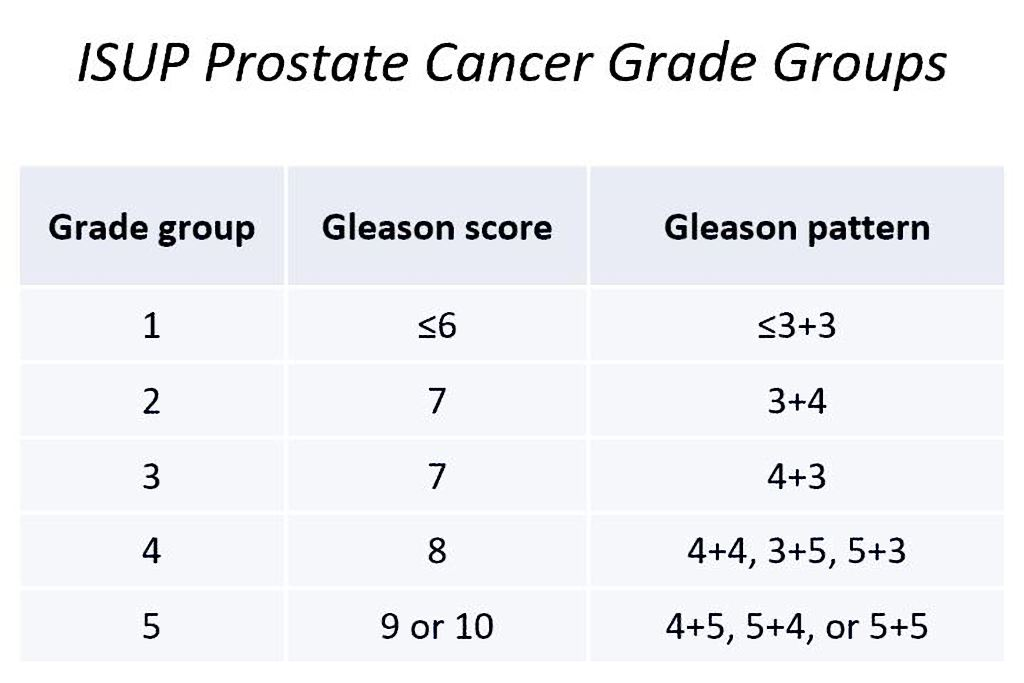

In [ ]:
temp = train.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)

In [ ]:
fig = px.bar(temp, x='isup_grade', y='image_id',
             hover_data=['image_id', 'isup_grade'], color='image_id',
             labels={'image_id':'Amount of images', 'isup_grade':'ISUP Grade'}, height=400)
fig.show()

Praten over de verdeeldheid in de code, de imbalans van de data. Vermelden dat het model hier rekening mee zal houden en misschien andere oplossingen aankaarten (zoals gewoon opsporen kanker of niet)

In [ ]:
fig = px.pie(temp, names='isup_grade', values='image_id', title='Pie-Chart of ISUP_grade Distribution',
             labels={'image_id':'Amount of images', 'isup_grade':'ISUP Grade'}, color='isup_grade')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Er zal een bias zijn naar 0 en 1 -> balanceren of weigthen van data?
Misschien beter kijken naar Gleason score?

>Data providers

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=train)
for p in ax.patches:
    '''
    Courtesy of Rohit Singh for teaching me this
    https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline
    '''
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
                height +3,
                '{:1.2f}%'.format(100*height/10616),
                ha="center")

Tonen waar de data vandaan komt.

### Gleason Score
This is given after a pathologist has examined under a microscope cancerous tissue obtained from the needle biopsy. The cells identified are given a grade number from 1 to 5, depending on the abnormality of the cells, 1 being the lowest, 5 the highest. The grades of the two most common patterns are added together to give a score from 2 to 10. The higher the score, the more aggressive and fast-growing the cancer. Scores totalling 5 or less are insignificant and are not reported.


    A Gleason score of 6 (cells are well differentiated) is ‘favourable’
    A Gleason score of 7 (cells are moderately differentiated) is ‘average’
    A Gleason Score of 8–10 (cells are poorly differentiated) is ‘adverse’


Uit https://tackleprostate.org/the-gleason-score.php

In [ ]:
temp = train.groupby('gleason_score').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)

In [ ]:
fig = px.bar(temp, x='gleason_score', y='image_id',
             hover_data=['image_id', 'gleason_score'], color='image_id',
             labels={'image_id':'Amount of images', 'gleason_score':'Gleason Score'}, height=400)
fig.show()

Zorgen dat in het trainen de verhouding behouden wordt zonder bias te introduceren. Stratified K-fold.

In [ ]:
fig = px.pie(temp, names='gleason_score', values='image_id', title='Pie-Chart of Gleason Grade Distribution',
             labels={'image_id':'Amount of images', 'gleason_score':'Gleason Score'}, color='gleason_score')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

>Data providers

In [ ]:


'''
Visualizing the GLEASON_SCORE distribution wrt Data_providers
'''

fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="gleason_score", hue="data_provider", data=train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/10616),
                ha="center")



## Werken met OpenSlide

In [ ]:
print(train.loc[lambda train: train['image_id'] == '3752b697cae9f81a9d5ffe44dac58e7a', 'gleason_score'].item())

In [ ]:
def show_images(image_batch, max_size=(600,400)):
    f,axs =  plt.subplots(3,3,figsize=(16,16))
    counter = {'0': 0, '1': 0}
    for afbeelding in image_batch:
        slide = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", f'{afbeelding}.tiff'))
        #print(counter)
        axs[counter['0'], counter['1']].imshow(slide.get_thumbnail(size=max_size)) #UNZOOMED FIGURE
        axs[counter['0'], counter['1']].set_title(
            f"Gleason grade: {train.loc[lambda train: train['image_id'] == afbeelding, 'gleason_score'].item()}\nISUP score: {train.loc[lambda train: train['image_id'] == afbeelding, 'isup_grade'].item()}")
        
        if counter['0'] == 2:
            counter['1'] += 1
            counter['0'] = 0
        else:
            counter['0'] += 1
    
    plt.show()

Wat foto's van de verschillende centra tonen. Polsen of de coupes in Az Delta er gelijkaardig uitzien.

## Radboud

In [ ]:
batch_radboud = train[train['data_provider']=='radboud']['image_id'].sample(9)
show_images(batch_radboud)

## Karolinska

In [ ]:
batch_karolinska = train[train['data_provider']=='karolinska']['image_id'].sample(9)
show_images(batch_karolinska)

## Image to tiles

In [ ]:
DEBUG = True

data_dir = '../input/prostate-cancer-grade-assessment'
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'how_to_train_effnet_b0_to_get_LB_0.86'

enet_type = 'efficientnet-b0'
fold = 0
tile_size = 128
image_size = 128
n_tiles = 16
batch_size = 1
num_workers = 0
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 30
train = train.sample(100).reset_index(drop=True) if DEBUG else train

#device = torch.device('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_folder)
print(device)

In [ ]:
!nvidia-smi

Van https://www.kaggle.com/iafoss/panda-16x128x128-tiles

In [ ]:
def get_tiles(img, sz=128, N=16):
    result = []
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    # Padden als er nog niet genoeg tiles aantwezig zijn (met volledig witte tiles)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    # Reshapen naar M x (3 x sz x sz) dan laatste dimensie sommeren = M values -> sorteren en de N laagste pakken 
    # (die hebben het minste aantal witte pixels = value 255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'idx':i})
    return result

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(train, train['isup_grade'])):
    try:
        train.loc[valid_idx, 'fold'] = i
    except Exception as exc:
        print(exc)
        continue
train.head()

In [ ]:
class PANDADataset(Dataset):
    def __init__(self,
                df,
                image_size,
                n_tiles=16,
                tile_mode=0,
                rand=False,
                transform=None):
        
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[0]
        tiles = get_tiles(image, sz=self.image_size, N=self.n_tiles)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [ ]:
pretrained_model = {
    'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'
}



class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x



In [ ]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

### Tiling tonen

Een methode om de overbodige data te verwijderen en alle foto's naar dezelfde dimensie te krijgen.

Verlies aan data? Grootte van windows aanpassen? Zijn er gehele structuren die verloren gaan?

In [ ]:
dataset_show = PANDADataset(train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

Planning voor later uitleggen.

* Modellen van Kaggle hanteren en "hertrainen" op de data van Az Delta.
* Zelf modellen maken hier een aanpassen voor Az Delta
* Hier technieken leren en deze dan combineren met de expertise van doktoren om in Az Delta een model te bouwen 

Vragen:

* Grootte van data
* Consistentie van data (dezelfde dimensies?)
* Geen te groot verlies aan data door tiling? Stretchen van afbeelding zeker geen goed idee?
* Opslag, transfer van data voorzien? Waarmee trainen?

### Model maken

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
df_train = train

In [ ]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [ ]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

In [ ]:
qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    #with open(f'log_{kernel_type}.txt', 'a') as appender:
    #    appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        #torch.save(model.state_dict(), best_file)
        qwk_max = qwk

#torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

In [ ]:
qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    #with open(f'log_{kernel_type}.txt', 'a') as appender:
    #    appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        #torch.save(model.state_dict(), best_file)
        qwk_max = qwk

#torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

# JJShadow emsemble

Modellen inladen en predicten op 

In [ ]:
Shujun_PRED_LIST=[]
for pred_list_index in range(len(ensemble_shujun_list[:-2])):
    Shujun_PRED_LIST.append([])


for phase_index, ensemble_recipe in enumerate(ensemble_shujun_list[:-2]):
    print("shujun_ensemble_phase",phase_index)

    MODELS=[]
    top=3
    num_classes=[6,4,4,]

    if ensemble_recipe['tileImageSize'] == 288:
        print("top_fold is 3")
        top_fold = 3 ## just 2 phase.. 4th ensemble model's top fold is 3(20x288x288)
    else:
        top_fold = 2
    for i in range(top_fold,top_fold+1):
        for j in range(top):
            
            if ensemble_recipe['TILE_SIZE'] == 64: ## janey network.
                if debug:
                    print("Janey Network")
                model = JaneyNetwork(num_classes).to(device)
            else:
                model = Network(num_classes,arch = ensemble_recipe['arch']).to(device)
            model = model.to(device)
            model = nn.DataParallel(model)
            weights_paths=ensemble_recipe['path'].format(i,j+1)
            if debug:
                print(weights_paths)
            model.load_state_dict(torch.load(weights_paths))
            model.eval()
            MODELS.append(model) 

    ####shujun code output ###

    total_images=0
    ## janey model's batch is 8 for OOM
    if ensemble_recipe['TILE_SIZE'] == 64 or ensemble_recipe['tileImageSize'] == 288: ## janey network.
        batch_size=8
    else:
        batch_size=16
    if debug:
            print("batch_size",batch_size)
    if len(df)%batch_size==0:
        batches=int(len(df)/batch_size)
    else:
        batches=int(len(df)/batch_size)+1
    model.eval()
    predictions=[]
    mean=torch.Tensor(ensemble_recipe['mean']).to(device).reshape(1,1,3,1,1)
    std=torch.Tensor(ensemble_recipe['std']).to(device).reshape(1,1,3,1,1)
    if debug:
        print(mean)
        print(std)
    with torch.no_grad():
        for i in tqdm(range(batches)):
            paths=df.image_id[i*batch_size:(i+1)*batch_size].to_list()
            x=get_batch_of_image(paths, sz = ensemble_recipe['tileImageSize'], N = ensemble_recipe['TILE_SIZE'], phase=phase_index, index_df = df)
            x0=torch.Tensor(x).to(device)
            x_h=torch.Tensor(x).to(device).flip(-1)
            x_v=torch.Tensor(x).to(device).flip(-2)
            x_vh=torch.Tensor(x).to(device).flip(-1,-2)
            x0t=torch.Tensor(x).to(device).transpose(-1,-2)
            x_ht=torch.Tensor(x).to(device).flip(-1).transpose(-1,-2)
            x_vt=torch.Tensor(x).to(device).flip(-2).transpose(-1,-2)
            x_vht=torch.Tensor(x).to(device).flip(-1,-2).transpose(-1,-2)
            outputs=[]
            isCutThresholdTile = ensemble_recipe['isCutThreshold']
            if debug:
                print('isCutThresholdTile',isCutThresholdTile)
            for model in MODELS:
                output = model(standardize_batch(x0,mean,std,isCutThresholdTile=isCutThresholdTile))[0]+\
                         model(standardize_batch(x_h,mean,std,isCutThresholdTile=isCutThresholdTile))[0]+\
                         model(standardize_batch(x_v,mean,std,isCutThresholdTile=isCutThresholdTile))[0]+\
                         model(standardize_batch(x_vh,mean,std,isCutThresholdTile=isCutThresholdTile))[0]+\
                         model(standardize_batch(x0t,mean,std,isCutThresholdTile=isCutThresholdTile))[0]+\
                         model(standardize_batch(x_ht,mean,std,isCutThresholdTile=isCutThresholdTile))[0]+\
                         model(standardize_batch(x_vt,mean,std,isCutThresholdTile=isCutThresholdTile))[0]+\
                         model(standardize_batch(x_vht,mean,std,isCutThresholdTile=isCutThresholdTile))[0]


                output=output.cpu().numpy()/8
                outputs.append(output)
            outputs=np.asarray(outputs)
            outputs=np.mean(outputs,axis=0)

            predictions.append(output)
    for pred in predictions:
        Shujun_PRED_LIST[phase_index].extend(pred)
    
    del output, predictions ### fix OOM memory issue.. hope..
    torch.cuda.empty_cache()


#### here shujun ensemble.. ####
if debug:
    for check_p_index in range(len(Shujun_PRED_LIST)):
        print(len(Shujun_PRED_LIST[check_p_index]))
    print("at last ensemble phase")

shujun_pred_list = np.asarray(Shujun_PRED_LIST)

print("shape",shujun_pred_list.shape)
if debug:
    print(Aksell_PRED_LIST) 
    print(Shujun_PRED_LIST) 
total_list = np.vstack((np.asarray(Aksell_PRED_LIST),np.asarray(Shujun_PRED_LIST))).transpose()
#shujun_ensemble_preds = np.asarray(PRED_LIST).mean(axis=0) ## shujun ensemble here

# Werken met TPU


# Zelf proberen


In [ ]:
data_dir = '../input/prostate-cancer-grade-assessment'
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_folder)
print(device)